<a href="https://colab.research.google.com/github/drkbluescience/TimeSeries-ML/blob/main/Preprocessing_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import random

import numpy as np
from numpy.fft import *
from numpy import dot
from numpy.linalg import norm

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

from google.colab import drive
import os

In [ ]:
drive.mount('/content/gdrive')

In [13]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/"

## Dataset 1- Passengers

In [4]:
!kaggle datasets download -d rakannimer/air-passengers
!unzip \*.zip  && rm *.zip

  0% 0.00/764 [00:00<?, ?B/s]
100% 764/764 [00:00<00:00, 1.84MB/s]
Archive:  air-passengers.zip
  inflating: AirPassengers.csv       


In [2]:
passenger = pd.read_csv('AirPassengers.csv')
passenger.rename(columns={"#Passengers": "Passengers"}, inplace=True)

#Sort the values according to dates.
passenger.sort_values(by=['Month'], inplace=True, ascending=True)

passenger = passenger.astype({"Passengers": np.float32})
passenger.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


# Missing Value Imputation in Time Series
**Interpolation**

- Linear Interpolation
- Spline Interpolation
- Polynomial Interpolation
- Pad Interpolation

In [3]:
def visualization(x_val, y_val, title, x, y):
  figure(figsize=(8, 5), dpi=80, linewidth=10)
  plt.plot(x_val, y_val)
  plt.title(title)
  plt.xlabel(x, fontsize=14)
  plt.ylabel(y, fontsize=14)
  plt.show()


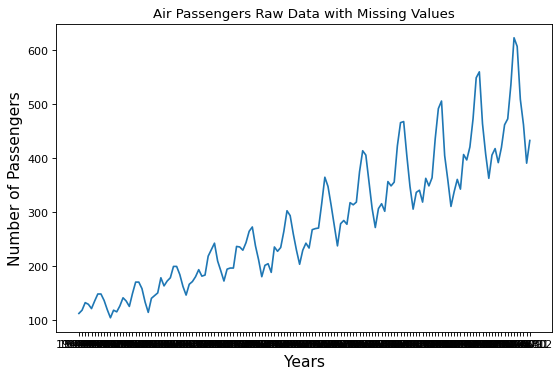

In [4]:
visualization(passenger['Month'],
              passenger['Passengers'],
              'Air Passengers Raw Data with Missing Values', 'Years', 'Number of Passengers')

As you see above there is no missing value. So, Let's generate some None data.

In [5]:
ix = [(row, 2) for row in range(passenger.shape[0])]

passenger["Passengers_n"] = passenger['Passengers']
for row, col in random.sample(ix, int(round(.1*len(ix)))):
    passenger.iat[row, col] = np.nan

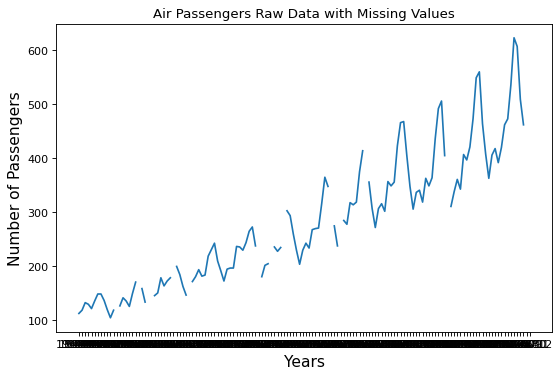

In [6]:
visualization(passenger['Month'],
              passenger['Passengers_n'],
              'Air Passengers Raw Data with Missing Values', 'Years', 'Number of Passengers')

In [7]:
passenger

,Month,Passengers,Passengers_n
0,1949-01,112.0,112.0
1,1949-02,118.0,118.0
2,1949-03,132.0,132.0
3,1949-04,129.0,129.0
4,1949-05,121.0,121.0
...,...,...,...
139,1960-08,606.0,606.0
140,1960-09,508.0,508.0
141,1960-10,461.0,461.0
142,1960-11,390.0,NaN


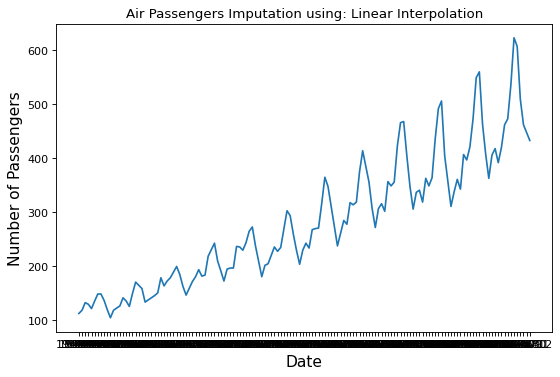

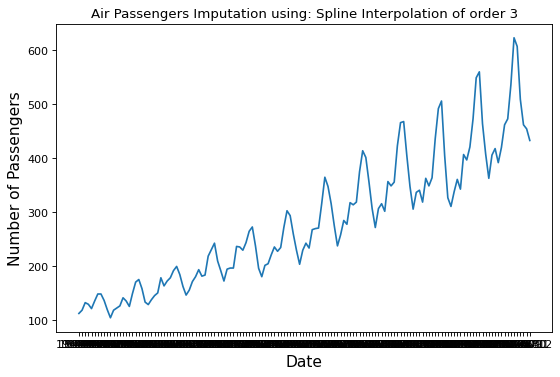

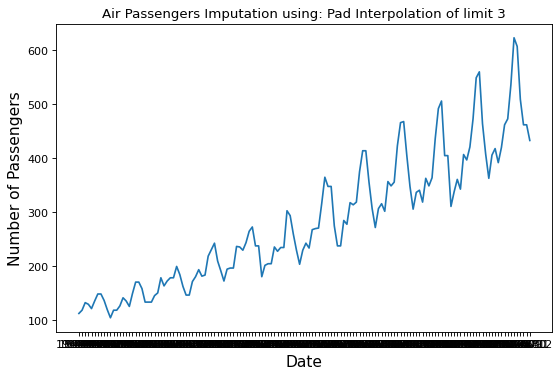

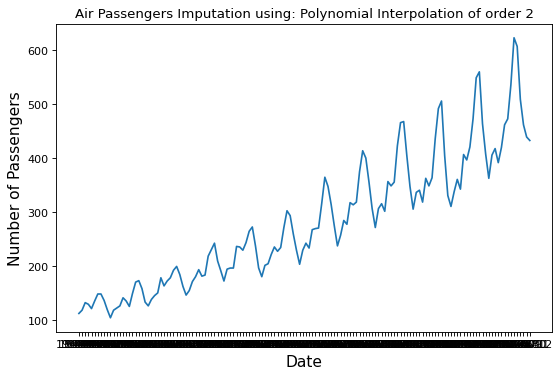

In [8]:
methods = ['Linear', 'Spline', 'Pad', 'Polynomial']

passenger[methods[0]] = passenger['Passengers_n'].interpolate(method='linear')
passenger[methods[1]] = passenger['Passengers_n'].interpolate(method='spline', order=3)
passenger[methods[2]] = passenger['Passengers_n'].interpolate(method='pad', limit=3, limit_direction='forward')
passenger[methods[3]] = passenger['Passengers_n'].interpolate(method='polynomial', order=2)


types=["Linear Interpolation", "Spline Interpolation of order 3", "Pad Interpolation of limit 3", "Polynomial Interpolation of order 2"]

i = 0
for method in methods:
  visualization(passenger["Month"],
                passenger[method],
                "".join(['Air Passengers Imputation using: ', types[i]]),
                "Date", "Number of Passengers")
  i += 1

In [9]:
passenger

,Month,Passengers,Passengers_n,Linear,Spline,Pad,Polynomial
0,1949-01,112.0,112.0,112.0,112.000000,112.0,112.000000
1,1949-02,118.0,118.0,118.0,118.000000,118.0,118.000000
2,1949-03,132.0,132.0,132.0,132.000000,132.0,132.000000
3,1949-04,129.0,129.0,129.0,129.000000,129.0,129.000000
4,1949-05,121.0,121.0,121.0,121.000000,121.0,121.000000
...,...,...,...,...,...,...,...
139,1960-08,606.0,606.0,606.0,606.000000,606.0,606.000000
140,1960-09,508.0,508.0,508.0,508.000000,508.0,508.000000
141,1960-10,461.0,461.0,461.0,461.000000,461.0,461.000000
142,1960-11,390.0,NaN,446.5,453.447021,461.0,438.421844


The four methods in total were used to fill nan points along with interpolation based on the range of discrete values. Sure, in the output circumstances, it would be comprehensive to descript the distances measured between the original and new columns.
Cosine similarity used to measure distances, followed by the results as specific to data and methods with certain parameters, are sorted descending order.

In [10]:
def cosine_similarity(a, b):
  return dot(a, b)/(norm(a)*norm(b))


In [11]:
columns = passenger.columns.to_list()

distances = {}
for i in range(3, len(columns)):
  cs = cosine_similarity(passenger['Passengers'].values, passenger[columns[i]].values)
  distances[cs] = columns[i]

distances = dict(sorted(distances.items(), reverse=True))


print("Similarity distance between Passengers and, \n")
for i, j in distances.items():
  print(f"{j} = {i}")


Similarity distance between Passengers and, 

Polynomial = 0.9997978210449219
Linear = 0.9997863173484802
Spline = 0.9997255206108093
Pad = 0.9995172023773193


#Dataset 2- Google Stock Price

In [ ]:
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231
!unzip \*.zip  && rm *.zip

# Denoising a Time Series

### Rolling
The Rolling mean refers to the average computed over a specific window of past observations, with the window consisting of a sequence of values from the time series dataset. A mean value is determined for each consecutive window, which proves highly beneficial in reducing the presence of noise within the time series data.

In [15]:
# Get the Google stock data among the files
google_stock_price = pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv")
google_stock_price.head(10)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
5,2006-01-10,232.44,235.36,231.25,235.11,9104719,GOOGL
6,2006-01-11,235.87,237.79,234.82,236.05,9008664,GOOGL
7,2006-01-12,237.10,237.73,230.98,232.05,10125212,GOOGL
8,2006-01-13,232.39,233.68,231.04,233.36,7660220,GOOGL
9,2006-01-17,231.76,235.18,231.50,233.79,8335300,GOOGL


In [16]:
google_stock_price.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3019.0,4.282008e+02,2.363200e+02,131.39,247.775,310.48,572.140,1083.02
High,3019.0,4.318356e+02,2.375141e+02,134.82,250.190,312.81,575.975,1086.49
Low,3019.0,4.241303e+02,2.349237e+02,123.77,244.035,307.79,565.900,1072.27
Close,3019.0,4.280440e+02,2.363432e+02,128.85,247.605,310.08,570.770,1085.09
Volume,3019.0,3.551504e+06,3.038599e+06,521141.00,1760854.000,2517630.00,4242182.500,41182889.00


In [17]:
def visualization_double(time, value1, value2, legend, fontsize = 13):
  plt.plot(time, value1)
  plt.plot(time, value2)
  plt.xlabel('Date', fontsize = fontsize)
  plt.ylabel('Stock Price', fontsize = fontsize)
  plt.legend(legend)
  plt.show()

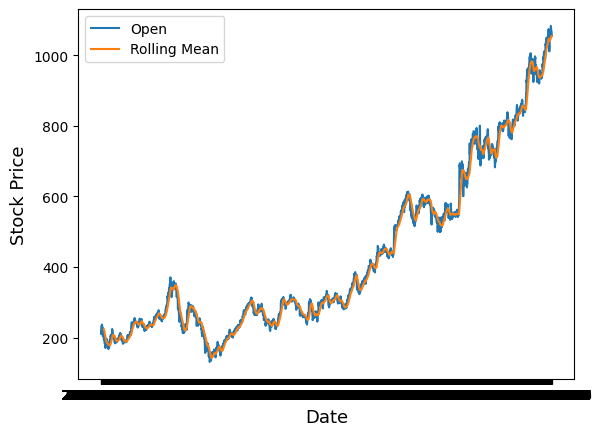

In [18]:
rolling_google = google_stock_price['Open'].rolling(20).mean()

time = google_stock_price['Date']
value = google_stock_price['Open']

visualization_double(time, value, rolling_google, ['Open','Rolling Mean'])

### Fourier Transform
Fourier Transform can help remove the noise by converting the time series data into the frequency domain, and from there, we can filter out the noisy frequencies. Then, we can apply the inverse Fourier transform to obtain the filtered time series.

In [19]:
def fft_denoiser(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

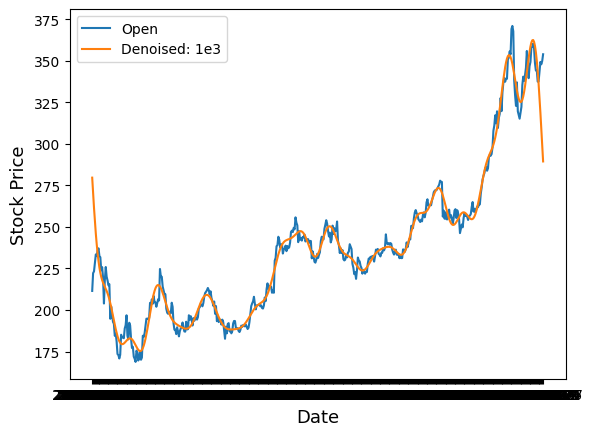

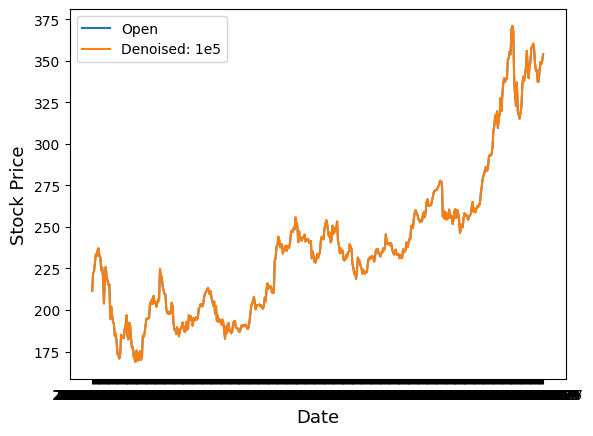

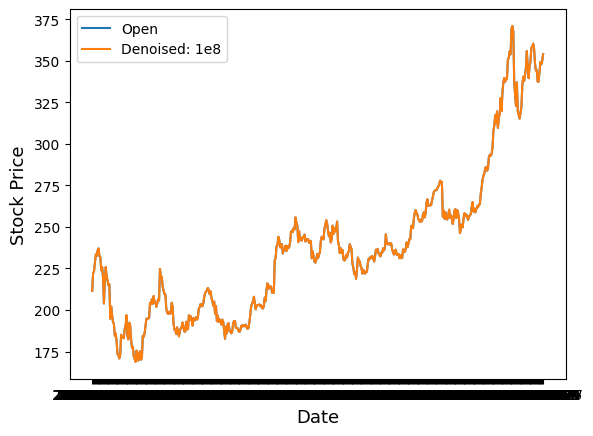

In [22]:
time = google_stock_price['Date'][0:500]
value = google_stock_price['Open'][0:500]


denoised_stock_price1 = fft_denoiser(value)
denoised_stock_price2 = fft_denoiser(value, 1e5)
denoised_stock_price3 = fft_denoiser(value, 1e8)


visualization_double(time, value, denoised_stock_price1, ['Open','Denoised: 1e3'])
visualization_double(time, value, denoised_stock_price2, ['Open','Denoised: 1e5'])
visualization_double(time, value, denoised_stock_price3, ['Open','Denoised: 1e8'])

In [ ]:
# Done!